## 0. 드라이브 마운트, 디폴트 경로 세팅

In [2]:
from google.colab import drive
from pathlib import Path
import os

BASE = Path("/content")
BASE.mkdir(parents=True, exist_ok=True)

print("BASE =", BASE)

BASE = /content


In [ ]:
from google.colab import drive
from pathlib import Path
import shutilz``

drive.mount("/content/drive")

DRIVE_RAW = Path("/content/drive/MyDrive/capstone_reliability/aihub/raw")
LOCAL_RAW = BASE / "aihub/raw"

if not (LOCAL_RAW / "videos").exists():
    shutil.copytree(DRIVE_RAW / "videos", LOCAL_RAW / "videos")
if not (LOCAL_RAW / "labels").exists():
    shutil.copytree(DRIVE_RAW / "labels", LOCAL_RAW / "labels")

print("Local raw:", LOCAL_RAW)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Local raw: /content/aihub/raw


## 1. import

In [3]:
!pip -q install -U "pandas==2.2.2"
!pip -q install -U "ultralytics==8.4.14" opencv-python-headless albumentations pyyaml tqdm psutil

import sys, platform, torch
import ultralytics

print("python   :", sys.version)
print("platform :", platform.platform())
print("torch    :", torch.__version__)
print("cuda avail:", torch.cuda.is_available())
print("cuda ver  :", torch.version.cuda)
print("gpu name  :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)
print("ultralytics:", ultralytics.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 kB 20.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
python   : 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
platform : Linux-6.6.113+-x86_64-with-glibc2.35
torch    : 2.10.0+cu128
cuda avail: True
cuda ver  : 12.8
gpu name  : Tesla T4
ultralytics: 8.4.14


## 2. 데이터, 산출물 폴더 + 시나리오 정의

In [5]:
from dataclasses import dataclass
from pathlib import Path

RAW_DIR   = BASE / "aihub/raw"
RAW_VID   = RAW_DIR / "videos"
RAW_JSON  = RAW_DIR / "labels"

DATASETS  = BASE / "datasets"
REPORTS   = BASE / "reports"
TMP       = BASE / "tmp"

for p in [RAW_VID, RAW_JSON, DATASETS, REPORTS, TMP]:
    p.mkdir(parents=True, exist_ok=True)

MAX_VIDEOS = None
MAX_IMAGES_TOTAL = None
SKIP_EXISTING = True

@dataclass(frozen=True)
class Scenario:
    name: str
    light: str
    weather: str
    res: str

SCENARIOS = [
    Scenario("TC0", "L1", "W1", "S1"),
    Scenario("TC1", "L2", "W1", "S1"),
    Scenario("TC2", "L3", "W1", "S1"),
    Scenario("TC3", "L1", "W2", "S1"),
    Scenario("TC4", "L1", "W3", "S1"),
    Scenario("TC5", "L1", "W1", "S3"),
    Scenario("TC6", "L3", "W3", "S3"),
]

print("RAW_VID:", RAW_VID)
print("RAW_JSON:", RAW_JSON)
print("DATASETS:", DATASETS)
print("REPORTS:", REPORTS)

RAW_VID: /content/aihub/raw/videos
RAW_JSON: /content/aihub/raw/labels
DATASETS: /content/datasets
REPORTS: /content/reports


## 3. 입력(파일) 체크

In [7]:
from pathlib import Path

mp4s = sorted(Path(RAW_VID).glob("*.mp4"))
jsons = sorted(Path(RAW_JSON).glob("*.json"))

print("mp4 count :", len(mp4s))
print("json count:", len(jsons))
print("mp4 sample :", [p.name for p in mp4s[:3]])
print("json sample:", [p.name for p in jsons[:3]])

assert len(mp4s) > 0, f"MP4 없음 RAW_VID: {RAW_VID}"
assert len(jsons) > 0, f"JSON 없음 RAW_JSON: {RAW_JSON}"

mp4 count : 5
json count: 5
mp4 sample : ['C_32_7_smp_su_09-11_10-41-00_a_for_DF2.mp4', 'C_32_7_smp_su_09-11_10-41-00_b_for_DF2.mp4', 'C_32_7_smp_su_09-11_10-41-00_c_for_DF2.mp4']
json sample: ['C_32_7_smp_su_09-11_10-41-00_a_for_DF2.json', 'C_32_7_smp_su_09-11_10-41-00_b_for_DF2.json', 'C_32_7_smp_su_09-11_10-41-00_c_for_DF2.json']


## 4. 모델 로드

In [8]:
from ultralytics import YOLO
import torch

def load_model_gpu():
    try:
        m = YOLO("yolo26n.pt")
        name = "yolo26n.pt"
    except Exception as e:
        print("[WARN] YOLO26 load failed -> fallback YOLOv8n:", e)
        m = YOLO("yolov8n.pt")
        name = "yolov8n.pt"
    return m, name

model, model_name = load_model_gpu()
print("Loaded:", model_name)
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)

Loaded: yolo26n.pt
GPU: Tesla T4


## 5. TC0 생성

In [9]:
import json, cv2
from pathlib import Path
from collections import defaultdict
from tqdm.auto import tqdm

TC0_ROOT = DATASETS / "TC0"
TC0_IMG  = TC0_ROOT / "images" / "val"
TC0_LAB  = TC0_ROOT / "labels" / "val"
TC0_IMG.mkdir(parents=True, exist_ok=True)
TC0_LAB.mkdir(parents=True, exist_ok=True)

def yolo_line_from_bbox_xyxy(x1,y1,x2,y2,w,h,cls=0):
    xc = ((x1+x2)/2.0) / w
    yc = ((y1+y2)/2.0) / h
    bw = (x2-x1) / w
    bh = (y2-y1) / h
    xc = min(max(xc, 0.0), 1.0); yc = min(max(yc, 0.0), 1.0)
    bw = min(max(bw, 0.0), 1.0); bh = min(max(bh, 0.0), 1.0)
    return f"{cls} {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}"

def build_tc0_from_json(json_path: Path):
    data = json.loads(json_path.read_text(encoding="utf-8"))

    mp4_name = data["info"]["filename"]
    video_path = Path(RAW_VID) / mp4_name
    if not video_path.exists():
        raise FileNotFoundError(f"Video not found: {video_path}")

    w = int(data["info"]["width"]); h = int(data["info"]["height"])
    label_fps = float(data["info"]["fps"])
    declared_frame = int(data["info"]["frame"])

    frame_to_lines = defaultdict(list)
    frames_seen = []

    # annotations: cur_frame + bbox=[[x1,y1],[x2,y2]]
    for ann in data.get("annotations", []):
        fr = int(ann["cur_frame"])
        frames_seen.append(fr)
        (x1,y1),(x2,y2) = ann["bbox"]
        frame_to_lines[fr].append(yolo_line_from_bbox_xyxy(x1,y1,x2,y2,w,h,cls=0))  # 일단 사람만

    for ev in data.get("events", []):
        if "ev_start_frame" in ev: frames_seen.append(int(ev["ev_start_frame"]))
        if "ev_end_frame" in ev: frames_seen.append(int(ev["ev_end_frame"]))

    if not frames_seen:
        raise ValueError(f"No frame indices found in {json_path.name}")

    start_frame = min(frames_seen)
    end_frame = max(max(frames_seen), declared_frame)

    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video: {video_path}")

    vid_fps = cap.get(cv2.CAP_PROP_FPS) or label_fps
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)

    ratio = (vid_fps / label_fps) if label_fps > 0 else 1.0

    # 0-based/1-based offset 추정
    max_label_fr = max(frames_seen)
    offset = -1 if (total_frames > 0 and max_label_fr >= total_frames) else 0

    # end_frame을 영상 범위로 클램프
    if total_frames > 0:
        max_label_index_allowed = int((total_frames - 1) / ratio) - offset
        end_frame = min(end_frame, max_label_index_allowed)

    video_id = Path(mp4_name).stem
    out_img_dir = TC0_IMG / video_id
    out_lab_dir = TC0_LAB / video_id
    out_img_dir.mkdir(parents=True, exist_ok=True)
    out_lab_dir.mkdir(parents=True, exist_ok=True)

    label_frames = list(range(start_frame, end_frame + 1))

    actual_to_label = defaultdict(list)
    for k in label_frames:
        actual_idx = int((k + offset) * ratio)  # 프레임 매칭
        if actual_idx < 0:
            continue
        actual_to_label[actual_idx].append(k)

    max_needed = max(actual_to_label.keys()) if actual_to_label else -1

    idx = 0
    saved = 0
    pbar = tqdm(total=max_needed+1, desc=f"Extract {video_id}", leave=False)
    while True:
        ok, frame = cap.read()
        if not ok:
            break
        if idx in actual_to_label:
            for k in actual_to_label[idx]:
                out_path = out_img_dir / f"{k:06d}.jpg"
                cv2.imwrite(str(out_path), frame)
                saved += 1
        idx += 1
        pbar.update(1)
        if idx > max_needed:
            break
    pbar.close()
    cap.release()

    # 라벨 txt 생성
    for k in label_frames:
        lab_path = out_lab_dir / f"{k:06d}.txt"
        lines = frame_to_lines.get(k, [])
        lab_path.write_text(("\n".join(lines) + "\n") if lines else "", encoding="utf-8")

    return {
        "video_id": video_id,
        "mp4": mp4_name,
        "label_fps": float(label_fps),
        "video_fps": float(vid_fps),
        "total_frames": int(total_frames),
        "offset_used": int(offset),
        "start_frame": int(start_frame),
        "end_frame": int(end_frame),
        "images_saved": int(saved),
        "label_frames": int(len(label_frames))
    }

summaries = []
json_list = sorted(Path(RAW_JSON).glob("*.json"))
if MAX_VIDEOS is not None:
    json_list = json_list[:MAX_VIDEOS]

for jp in tqdm(json_list, desc="Build TC0"):
    summaries.append(build_tc0_from_json(jp))

summaries[:2], len(summaries)


Build TC0:   0%|          | 0/5 [00:00<?, ?it/s]

Extract C_32_7_smp_su_09-11_10-41-00_a_for_DF2:   0%|          | 0/202 [00:00<?, ?it/s]

Extract C_32_7_smp_su_09-11_10-41-00_b_for_DF2:   0%|          | 0/202 [00:00<?, ?it/s]

Extract C_32_7_smp_su_09-11_10-41-00_c_for_DF2:   0%|          | 0/201 [00:00<?, ?it/s]

Extract C_32_7_smp_su_09-11_10-42-00_a_for_DF2:   0%|          | 0/200 [00:00<?, ?it/s]

Extract C_32_7_smp_su_09-11_10-42-00_b_for_DF2:   0%|          | 0/200 [00:00<?, ?it/s]

([{'video_id': 'C_32_7_smp_su_09-11_10-41-00_a_for_DF2',
   'mp4': 'C_32_7_smp_su_09-11_10-41-00_a_for_DF2.mp4',
   'label_fps': 3.0,
   'video_fps': 3.0,
   'total_frames': 202,
   'offset_used': 0,
   'start_frame': 21,
   'end_frame': 201,
   'images_saved': 181,
   'label_frames': 181},
  {'video_id': 'C_32_7_smp_su_09-11_10-41-00_b_for_DF2',
   'mp4': 'C_32_7_smp_su_09-11_10-41-00_b_for_DF2.mp4',
   'label_fps': 3.0,
   'video_fps': 3.0,
   'total_frames': 202,
   'offset_used': 0,
   'start_frame': 27,
   'end_frame': 201,
   'images_saved': 175,
   'label_frames': 175}],
 5)

## 6. 확인용 시각화

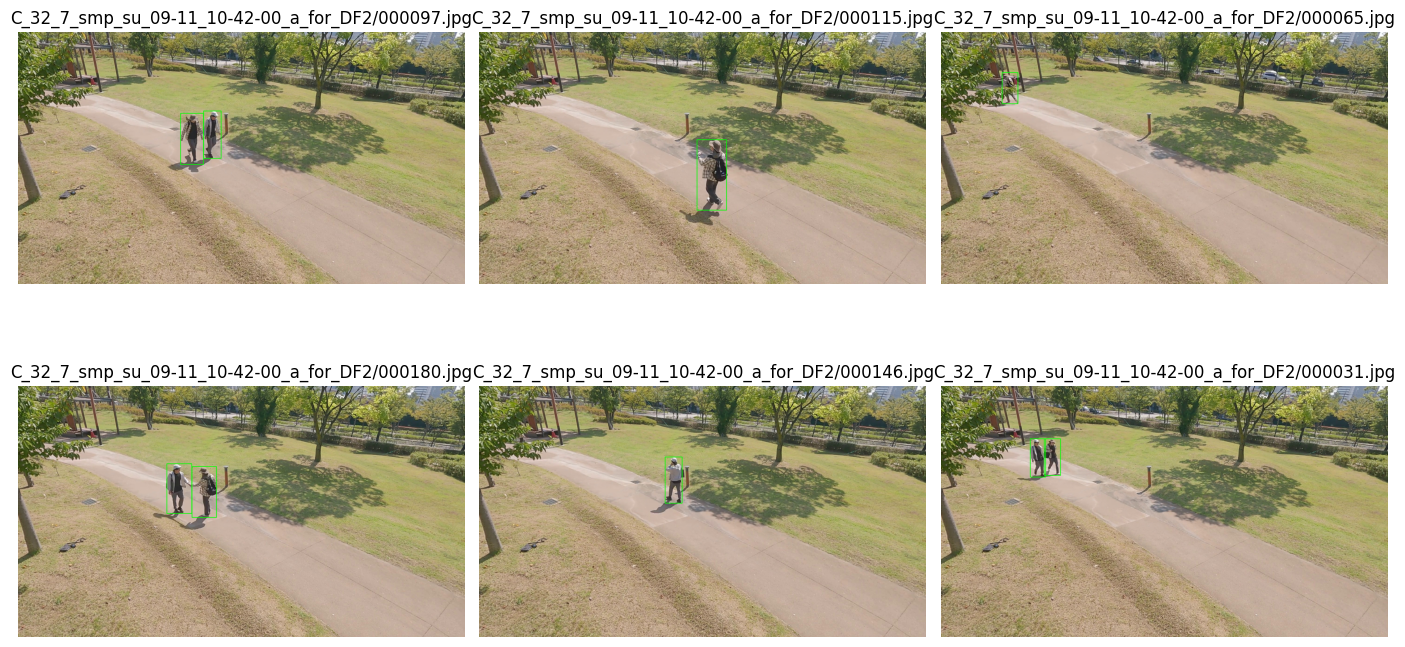

In [10]:
import random
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

def draw_yolo_boxes(img_path, lab_path):
    img = cv2.imread(str(img_path))
    if img is None:
        return None
    h, w = img.shape[:2]

    if lab_path.exists():
        lines = lab_path.read_text().strip().splitlines()
        for line in lines:
            if not line.strip():
                continue
            cls, xc, yc, bw, bh = line.split()
            xc, yc, bw, bh = map(float, (xc,yc,bw,bh))
            x1 = int((xc - bw/2) * w); y1 = int((yc - bh/2) * h)
            x2 = int((xc + bw/2) * w); y2 = int((yc + bh/2) * h)
            cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)

    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

vid_dirs = [p for p in TC0_IMG.iterdir() if p.is_dir()]
assert len(vid_dirs) > 0, "TC0 이미지 폴더가 빈폴더"
vid = random.choice(vid_dirs)
imgs = sorted(vid.glob("*.jpg"))
sample = random.sample(imgs, k=min(6, len(imgs)))

plt.figure(figsize=(14,8))
for i, ip in enumerate(sample, 1):
    lp = TC0_LAB / vid.name / f"{ip.stem}.txt"
    rgb = draw_yolo_boxes(ip, lp)
    if rgb is None:
        continue
    plt.subplot(2,3,i)
    plt.imshow(rgb)
    plt.title(f"{vid.name}/{ip.name}")
    plt.axis("off")
plt.tight_layout()
plt.show()


## 7. 열화 데이터셋 생성, 품질지표 저장

In [11]:
import os
import shutil
import time
import zlib
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import albumentations as A
from tqdm.auto import tqdm

cv2.setNumThreads(0)

assert DATASETS.exists(), f"DATASETS not found: {DATASETS}"
assert TC0_IMG.exists(), f"TC0 images not found: {TC0_IMG}"
assert TC0_LAB.exists(), f"TC0 labels not found: {TC0_LAB}"

def lap_var(gray):
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def brightness_contrast(bgr):
    yuv = cv2.cvtColor(bgr, cv2.COLOR_BGR2YUV)
    y = yuv[..., 0].astype(np.float32)
    return float(y.mean()), float(y.std())

def noise_proxy(gray):
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    resid = gray.astype(np.float32) - blur.astype(np.float32)
    mad = np.median(np.abs(resid - np.median(resid)))
    return float(mad)

def edge_density(gray):
    edges = cv2.Canny(gray, 80, 160)
    return float((edges > 0).mean())

def quality_metrics_from_bgr(bgr):
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    b_mean, b_std = brightness_contrast(bgr)
    return {
        "blur_lap_var": float(lap_var(gray)),
        "brightness_mean": b_mean,
        "brightness_std": b_std,
        "noise_mad": float(noise_proxy(gray)),
        "edge_density": float(edge_density(gray)),
    }

def deterministic_seed(scn_name: str, rel_path: str, base: int = 42) -> int:
    s = f"{scn_name}:{rel_path}".encode("utf-8")
    return base + (zlib.adler32(s) % 10_000_000)

def compose_with_seed(transforms, seed: int):
    try:
        return A.Compose(transforms, seed=int(seed))
    except TypeError:
        import random
        random.seed(int(seed))
        np.random.seed(int(seed))
        return A.Compose(transforms)

def gauss_noise_px(std_low_px: float, std_high_px: float, p: float):
    lo = std_low_px / 255.0
    hi = std_high_px / 255.0
    return A.GaussNoise(std_range=(lo, hi), mean_range=(0.0, 0.0), per_channel=True, p=p)

def build_transform(light: str, weather: str, res: str, seed: int):
    t = []

    # Light
    if light == "L2":
        t += [A.RandomBrightnessContrast(
            brightness_limit=(-0.35, -0.15),
            contrast_limit=(-0.1, 0.05),
            p=1.0
        )]
        t += [gauss_noise_px(10.0, 30.0, p=0.5)]

    elif light == "L3":
        t += [A.RandomBrightnessContrast(
            brightness_limit=(-0.65, -0.40),
            contrast_limit=(-0.2, 0.1),
            p=1.0
        )]
        t += [gauss_noise_px(20.0, 60.0, p=0.7)]
        t += [A.MotionBlur(blur_limit=7, p=0.3)]

    # Weather
    if weather == "W2":
        t += [A.RandomRain(
            blur_value=3,
            brightness_coefficient=0.9,
            rain_type="default",
            p=1.0
        )]
    elif weather == "W3":
        t += [A.RandomFog(
            fog_coef_lower=0.25,
            fog_coef_upper=0.55,
            alpha_coef=0.08,
            p=1.0
        )]

    # Resolution
    if res == "S3":
        t += [A.Downscale(
            scale_min=0.35,
            scale_max=0.5,
            interpolation_pair={"downscale": cv2.INTER_AREA, "upscale": cv2.INTER_LINEAR},
            p=1.0
        )]

    if not t:
        return None
    return compose_with_seed(t, seed)

# ---- Helpers ----
def clone_labels_from_tc0(dst_root: Path):
    dst_lab = dst_root / "labels" / "val"
    if dst_lab.exists():
        return
    dst_lab.parent.mkdir(parents=True, exist_ok=True)
    shutil.copytree(TC0_LAB, dst_lab)

def collect_tc0_images():
    items = []
    for vid_dir in sorted([p for p in TC0_IMG.iterdir() if p.is_dir()], key=lambda p: p.name):
        for img_path in sorted(vid_dir.glob("*.jpg"), key=lambda p: p.name):
            items.append((vid_dir.name, img_path))
    if MAX_IMAGES_TOTAL is not None:
        items = items[:MAX_IMAGES_TOTAL]
    return items

ALL_IMAGES = collect_tc0_images()
assert len(ALL_IMAGES) > 0, "TC0 이미지가 없습니다"

def build_scenario_dataset(scn):
    """
    scn별 images/val 생성 + (TC1~TC6) labels/val 복제 + quality_metrics.csv 저장
    TC0는 원본 그대로 사용
    """
    dst_root = DATASETS / scn.name
    dst_img_root = dst_root / "images" / "val"
    dst_img_root.mkdir(parents=True, exist_ok=True)

    # 라벨-> TC0는 이미 존재. TC1~TC6는 TC0 라벨 복제
    if scn.name != "TC0":
        clone_labels_from_tc0(dst_root)

    rows = []
    t0 = time.time()

    pbar = tqdm(
        ALL_IMAGES,
        desc=f"{scn.name} images",
        total=len(ALL_IMAGES),
        leave=False,
        mininterval=0.5
    )

    for vid, src_path in pbar:
        rel = f"{vid}/{src_path.name}"
        seed = deterministic_seed(scn.name, rel)

        if scn.name == "TC0":
            out_path = src_path
            bgr = cv2.imread(str(out_path))
            if bgr is None:
                continue
        else:
            out_vid = dst_img_root / vid
            out_vid.mkdir(parents=True, exist_ok=True)
            out_path = out_vid / src_path.name

            if SKIP_EXISTING and out_path.exists():
                bgr = cv2.imread(str(out_path))
                if bgr is None:
                    bgr = cv2.imread(str(src_path))
                    if bgr is None:
                        continue
            else:
                bgr = cv2.imread(str(src_path))
                if bgr is None:
                    continue

            tfm = build_transform(scn.light, scn.weather, scn.res, seed=seed)
            if tfm is not None:
                bgr = tfm(image=bgr)["image"]

            cv2.imwrite(str(out_path), bgr)

        qm = quality_metrics_from_bgr(bgr)
        qm.update({"scenario": scn.name, "video_id": vid, "frame": src_path.stem})
        rows.append(qm)

    df = pd.DataFrame(rows)
    df.to_csv(dst_root / "quality_metrics.csv", index=False)

    tqdm.write(f"[{scn.name}] done | images={len(df)} | elapsed={time.time()-t0:.1f}s")
    return dst_root, df

scenario_roots = {}
quality_dfs = {}

outer = tqdm(SCENARIOS, desc="Scenarios", leave=True)
for scn in outer:
    outer.set_postfix({"current": scn.name})
    root, qdf = build_scenario_dataset(scn)
    scenario_roots[scn.name] = root
    quality_dfs[scn.name] = qdf

print("Built:", list(scenario_roots.keys()))


Scenarios:   0%|          | 0/7 [00:00<?, ?it/s]

TC0 images:   0%|          | 0/894 [00:00<?, ?it/s]

[TC0] done | images=894 | elapsed=92.3s


TC1 images:   0%|          | 0/894 [00:00<?, ?it/s]

[TC1] done | images=894 | elapsed=158.7s


TC2 images:   0%|          | 0/894 [00:00<?, ?it/s]

[TC2] done | images=894 | elapsed=166.1s


TC3 images:   0%|          | 0/894 [00:00<?, ?it/s]

[TC3] done | images=894 | elapsed=118.7s


TC4 images:   0%|          | 0/894 [00:00<?, ?it/s]

/tmp/ipython-input-1235444029.py:117: UserWarning: Argument(s) 'fog_coef_lower, fog_coef_upper' are not valid for transform RandomFog
  t += [A.RandomFog(


[TC4] done | images=894 | elapsed=897.0s


TC5 images:   0%|          | 0/894 [00:00<?, ?it/s]

/tmp/ipython-input-1235444029.py:126: UserWarning: Argument(s) 'scale_min, scale_max' are not valid for transform Downscale
  t += [A.Downscale(


[TC5] done | images=894 | elapsed=81.8s


TC6 images:   0%|          | 0/894 [00:00<?, ?it/s]

[TC6] done | images=894 | elapsed=923.8s
Built: ['TC0', 'TC1', 'TC2', 'TC3', 'TC4', 'TC5', 'TC6']


## 8. 품질 요약

In [12]:
import pandas as pd

base = quality_dfs["TC0"][["brightness_mean","brightness_std","edge_density","blur_lap_var","noise_mad"]].mean()

summary = []
for name, qdf in quality_dfs.items():
    m = qdf[["brightness_mean","brightness_std","edge_density","blur_lap_var","noise_mad"]].mean()
    r = (m / base).to_dict()
    summary.append({"scenario": name, **{f"ratio_{k}": float(v) for k,v in r.items()}})

summary_df = pd.DataFrame(summary).sort_values("scenario")
summary_df.to_csv(REPORTS / "quality_ratio_summary.csv", index=False)
summary_df


,scenario,ratio_brightness_mean,ratio_brightness_std,ratio_edge_density,ratio_blur_lap_var,ratio_noise_mad
0,TC0,1.000000,1.000000,1.000000,1.000000,1.000000
1,TC1,0.544965,0.922630,1.216282,3.170474,2.229418
2,TC2,0.202189,0.504976,0.973756,5.171828,2.514056
3,TC3,0.929474,0.964747,1.071623,1.183714,1.072791
4,TC4,1.051674,0.827679,0.000000,0.002155,0.000000
5,TC5,0.999273,0.895975,0.109458,0.019477,0.000000
6,TC6,0.314899,0.494451,0.000000,0.001909,0.000000


9. 신뢰성 5요소 시나리오 매핑표 생성해봄

In [14]:
import pandas as pd

DOT, TRI, NONE = "●", "△", "−"

#  매핑(이후 자세히 조정 필요)
mapping = [
    ("TC0", "Baseline(원본)",            TRI, NONE, TRI, NONE, DOT),
    ("TC1", "저조도(조명 L2)",            DOT, NONE, DOT, NONE, DOT),
    ("TC2", "극저조도+노이즈(L3)",        DOT, TRI, DOT, NONE, DOT),
    ("TC3", "우천 합성(W2)",              DOT, TRI, DOT, NONE, DOT),
    ("TC4", "안개 합성(W3)",              DOT, TRI, DOT, NONE, DOT),
    ("TC5", "저해상도(S3)",               TRI, NONE, DOT, NONE, DOT),
    ("TC6", "복합(L3+W3+S3)",             DOT, TRI, DOT, NONE, DOT),
]

scenario_map_df = pd.DataFrame(mapping, columns=[
    "시나리오", "설명", "Safety", "XAI", "Robust", "Fairness", "Transparency"
])

scenario_map_df.to_csv(REPORTS / "scenario_reliability_mapping_hwpx_style.csv", index=False)
scenario_map_df

CRITERIA = {
    "Safety": {"FPR_max": 0.05, "FNR_max": 0.10},
    "XAI": {"evidence_rate_min": 0.80, "consistency_min": 0.90},
    "Robust": {"mAP_min": 0.70, "IoU_min": 0.50},
    "Fairness": {"bias_max": 0.10},
    "Transparency": {"data_provenance_rate": 1.00},
}
CRITERIA

{'Safety': {'FPR_max': 0.05, 'FNR_max': 0.1},
 'XAI': {'evidence_rate_min': 0.8, 'consistency_min': 0.9},
 'Robust': {'mAP_min': 0.7, 'IoU_min': 0.5},
 'Fairness': {'bias_max': 0.1},
 'Transparency': {'data_provenance_rate': 1.0}}

## 10. 입력 파일 목록, 해시, 실패 목록 (투명성)

In [15]:
import hashlib
from pathlib import Path
import pandas as pd

def sha256_file(p: Path, block=1024*1024):
    h = hashlib.sha256()
    with p.open("rb") as f:
        while True:
            b = f.read(block)
            if not b: break
            h.update(b)
    return h.hexdigest()

rows = []
for p in sorted(list(Path(RAW_VID).glob("*.mp4")) + list(Path(RAW_JSON).glob("*.json"))):
    try:
        rows.append({
            "path": str(p),
            "name": p.name,
            "size_bytes": p.stat().st_size,
            "sha256": sha256_file(p),
        })
    except Exception as e:
        rows.append({
            "path": str(p),
            "name": p.name,
            "size_bytes": None,
            "sha256": None,
            "error": str(e)
        })

inv_df = pd.DataFrame(rows)
inv_df.to_csv(REPORTS / "input_inventory_sha256.csv", index=False)
print("Saved:", REPORTS / "input_inventory_sha256.csv")
inv_df.head()

Saved: /content/reports/input_inventory_sha256.csv


,path,name,size_bytes,sha256
0,/content/aihub/raw/labels/C_32_7_smp_su_09-11_...,C_32_7_smp_su_09-11_10-41-00_a_for_DF2.json,65372,828f5ab1036c9e3b11498fe2e28641d8e71ee255ace935...
1,/content/aihub/raw/labels/C_32_7_smp_su_09-11_...,C_32_7_smp_su_09-11_10-41-00_b_for_DF2.json,33024,3b36e85711b5c31ae3a380eed0f6fd789ab43b34c3e1f7...
2,/content/aihub/raw/labels/C_32_7_smp_su_09-11_...,C_32_7_smp_su_09-11_10-41-00_c_for_DF2.json,37882,29b74b6c2acdfe0dc74c27987b3e03513f9d484e476637...
3,/content/aihub/raw/labels/C_32_7_smp_su_09-11_...,C_32_7_smp_su_09-11_10-42-00_a_for_DF2.json,72745,6b2176ce3ae2870fb132cbee09e26a828143a359c890fa...
4,/content/aihub/raw/labels/C_32_7_smp_su_09-11_...,C_32_7_smp_su_09-11_10-42-00_b_for_DF2.json,32476,c1de6130ab57f46016744f4a43280f5481941884fcb93d...


## 11. 알람 기준 FPR/FNR 계산 (안정)

In [16]:
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

ALARM_CONF = 0.25
DEVICE = 0 if __import__("torch").cuda.is_available() else "cpu"

def iter_images(root: Path):
    for vid_dir in sorted([p for p in root.iterdir() if p.is_dir()], key=lambda p: p.name):
        for img_path in sorted(vid_dir.glob("*.jpg"), key=lambda p: p.name):
            yield vid_dir.name, img_path

def gt_person_present(label_root: Path, vid: str, frame_stem: str) -> int:
    lp = label_root / vid / f"{frame_stem}.txt"
    if not lp.exists():
        return 0
    txt = lp.read_text(encoding="utf-8").strip()
    return 1 if len(txt) > 0 else 0

def pred_alarm(model, img_path: Path, conf: float, device):
    r = model.predict(
        source=str(img_path),
        conf=conf,
        iou=0.7,
        device=device,
        verbose=False
    )[0]
    if r.boxes is None or len(r.boxes) == 0:
        return 0
    # 단일 클래스라면 개수>0이면 알람
    return 1

def safety_eval_scenario(scn_name: str):
    root = scenario_roots[scn_name]
    img_root = root / "images" / "val"
    lab_root = root / "labels" / "val" if scn_name != "TC0" else (DATASETS/"TC0"/"labels"/"val")

    y_true = []
    y_pred = []

    items = list(iter_images(img_root))
    if MAX_IMAGES_TOTAL is not None:
        items = items[:MAX_IMAGES_TOTAL]

    for vid, img_path in tqdm(items, desc=f"Safety {scn_name}", leave=False):
        gt = gt_person_present(lab_root, vid, img_path.stem)
        pr = pred_alarm(model, img_path, conf=ALARM_CONF, device=DEVICE)
        y_true.append(gt)
        y_pred.append(pr)

    y_true = np.array(y_true, dtype=np.int32)
    y_pred = np.array(y_pred, dtype=np.int32)

    TP = int(((y_true==1) & (y_pred==1)).sum())
    TN = int(((y_true==0) & (y_pred==0)).sum())
    FP = int(((y_true==0) & (y_pred==1)).sum())
    FN = int(((y_true==1) & (y_pred==0)).sum())

    fnr = FN / (TP+FN) if (TP+FN) > 0 else 0.0
    fpr = FP / (FP+TN) if (FP+TN) > 0 else 0.0
    acc = (TP+TN) / (TP+TN+FP+FN) if (TP+TN+FP+FN) > 0 else 0.0
    prec = TP / (TP+FP) if (TP+FP) > 0 else 0.0
    rec  = TP / (TP+FN) if (TP+FN) > 0 else 0.0

    return {
        "scenario": scn_name,
        "alarm_conf": ALARM_CONF,
        "TP": TP, "TN": TN, "FP": FP, "FN": FN,
        "FNR": float(fnr), "FPR": float(fpr),
        "alarm_accuracy": float(acc),
        "alarm_precision": float(prec),
        "alarm_recall": float(rec),
        "n_frames": int(len(y_true)),
    }

safety_rows = []
for scn in tqdm([s.name for s in SCENARIOS], desc="Safety(all)"):
    safety_rows.append(safety_eval_scenario(scn))

safety_df = pd.DataFrame(safety_rows).sort_values("scenario")
safety_df.to_csv(REPORTS / "safety_alarm_metrics.csv", index=False)
safety_df

Safety(all):   0%|          | 0/7 [00:00<?, ?it/s]

Safety TC0:   0%|          | 0/894 [00:00<?, ?it/s]

Safety TC1:   0%|          | 0/894 [00:00<?, ?it/s]

Safety TC2:   0%|          | 0/894 [00:00<?, ?it/s]

Safety TC3:   0%|          | 0/894 [00:00<?, ?it/s]

Safety TC4:   0%|          | 0/894 [00:00<?, ?it/s]

Safety TC5:   0%|          | 0/894 [00:00<?, ?it/s]

Safety TC6:   0%|          | 0/894 [00:00<?, ?it/s]

,scenario,alarm_conf,TP,TN,FP,FN,FNR,FPR,alarm_accuracy,alarm_precision,alarm_recall,n_frames
0,TC0,0.25,589,140,107,58,0.089645,0.433198,0.815436,0.846264,0.910355,894
1,TC1,0.25,573,183,64,74,0.114374,0.259109,0.845638,0.899529,0.885626,894
2,TC2,0.25,317,211,36,330,0.510046,0.145749,0.590604,0.898017,0.489954,894
3,TC3,0.25,506,198,49,141,0.217929,0.198381,0.787472,0.911712,0.782071,894
4,TC4,0.25,509,206,41,138,0.213292,0.165992,0.799776,0.925455,0.786708,894
5,TC5,0.25,589,186,61,58,0.089645,0.246964,0.866890,0.906154,0.910355,894
6,TC6,0.25,151,235,12,496,0.766615,0.048583,0.431767,0.926380,0.233385,894


## 12. 시나리오별 val 평가

In [17]:
import yaml
import time
import psutil
import torch
import pandas as pd
from tqdm.auto import tqdm
from pathlib import Path

IMG_SIZE = 640
BATCH = 16
CONF = 0.25
IOU = 0.7

def write_yaml_for_scenario(scn_name: str, root: Path):
    ypath = root / f"dataset_{scn_name}.yaml"
    data = {
        "path": str(root),
        "train": "images/val",
        "val": "images/val",
        "nc": 1,
        "names": {0: "person"},
    }
    ypath.write_text(yaml.safe_dump(data, sort_keys=False), encoding="utf-8")
    return ypath

yamls = {name: write_yaml_for_scenario(name, root) for name, root in scenario_roots.items()}

def eval_scenario_gpu(model, data_yaml: Path):
    t0 = time.time()
    res = model.val(
        data=str(data_yaml),
        imgsz=IMG_SIZE,
        batch=BATCH,
        conf=CONF,
        iou=IOU,
        device=0 if torch.cuda.is_available() else "cpu",
        verbose=False
    )
    t1 = time.time()

    gpu_mem = None
    if torch.cuda.is_available():
        gpu_mem = float(torch.cuda.max_memory_allocated() / (1024**2))

    return {
        "map50_95": float(getattr(res.box, "map", 0.0)),
        "map50": float(getattr(res.box, "map50", 0.0)),
        "precision": float(getattr(res.box, "mp", 0.0)),
        "recall": float(getattr(res.box, "mr", 0.0)),
        "val_seconds": t1 - t0,
        "ram_percent": psutil.virtual_memory().percent,
        "gpu_mem_mb_peak": gpu_mem
    }

rows = []
torch.cuda.reset_peak_memory_stats() if torch.cuda.is_available() else None

for name in tqdm(sorted(yamls.keys()), desc="Eval scenarios (GPU)"):
    yml = yamls[name]
    m = eval_scenario_gpu(model, yml)
    m.update({"scenario": name, "model": model_name})
    rows.append(m)

eval_df = pd.DataFrame(rows).sort_values("scenario")
base_row = eval_df[eval_df["scenario"]=="TC0"].iloc[0]
eval_df["d_map50_95"] = eval_df["map50_95"] - base_row["map50_95"]
eval_df["d_recall"]   = eval_df["recall"]   - base_row["recall"]

eval_df.to_csv(REPORTS / "eval_metrics_gpu.csv", index=False)
eval_df

Eval scenarios (GPU):   0%|          | 0/7 [00:00<?, ?it/s]

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4318.0±1216.8 MB/s, size: 976.7 KB)
val: Scanning /content/datasets/TC0/labels/val/C_32_7_smp_su_09-11_10-41-00_a_for_DF2... 894 images, 247 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 894/894 2.9Kit/s 0.3s
val: New cache created: /content/datasets/TC0/labels/val/C_32_7_smp_su_09-11_10-41-00_a_for_DF2.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 112/112 6.6it/s 17.0s
                   all        894        966      0.354      0.273      0.203      0.142
Speed: 1.0ms preprocess, 4.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /content/runs/detect/val
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1782.4±2187.2 MB/s, size: 1108.7 KB)
val: Scanning /content/datasets/TC1/labels/val/

,map50_95,map50,precision,recall,val_seconds,ram_percent,gpu_mem_mb_peak,scenario,model,d_map50_95,d_recall
0,0.142489,0.203147,0.354061,0.272933,21.632005,31.6,208.502441,TC0,yolo26n.pt,0.000000,0.000000
1,0.143232,0.211984,0.356180,0.273292,26.828298,33.8,208.502441,TC1,yolo26n.pt,0.000742,0.000359
2,0.108031,0.172334,0.295238,0.128364,27.728255,36.0,208.502441,TC2,yolo26n.pt,-0.034459,-0.144569
3,0.166663,0.241611,0.358166,0.258799,24.209630,37.6,208.502441,TC3,yolo26n.pt,0.024174,-0.014134
4,0.131757,0.210757,0.315718,0.241201,17.143499,39.2,208.502441,TC4,yolo26n.pt,-0.010732,-0.031732
5,0.147909,0.214941,0.346687,0.290051,20.790919,40.6,208.502441,TC5,yolo26n.pt,0.005420,0.017118
6,0.097081,0.159093,0.294118,0.051760,16.249920,42.3,208.502441,TC6,yolo26n.pt,-0.045408,-0.221173


13. 리포트

In [18]:
import json, shutil
from datetime import datetime

REPORT_DIR = REPORTS
REPORT_DIR.mkdir(parents=True, exist_ok=True)

meta = {
    "timestamp": datetime.now().isoformat(),
    "base": str(BASE),
    "model": model_name,
    "device": "cuda:0" if __import__("torch").cuda.is_available() else "cpu",
    "imgsz": IMG_SIZE,
    "batch": BATCH,
    "conf": CONF,
    "iou": IOU,
    "alarm_conf": ALARM_CONF,
    "scenarios": [s.__dict__ for s in SCENARIOS],
    "criteria_example_from_hwpx": CRITERIA,
}

(REPORT_DIR / "run_meta.json").write_text(
    json.dumps(meta, indent=2, ensure_ascii=False),
    encoding="utf-8"
)

md = []
md.append("# 영상탐지 AI체계 신뢰성 Pilot Test Report\n")
md.append(f"- Base: `{BASE}`\n")
md.append(f"- Model: `{model_name}`\n")
md.append(f"- Device: `{meta['device']}`\n")
md.append(f"- Scenarios: TC0~TC6\n")

md.append("\n## 1) 신뢰성 5대 항목(What to Test?)\n")
md.append("- 안전성(Safety) / 설명가능성(XAI) / 견고성(Robustness) / 공평성(Fairness) / 투명성(Transparency)\n")

md.append("\n## 2) 신뢰성 시험 평가 기준 예시(How to Measure?)\n")
md.append("| 항목 | 주요 지표 | 기준 예시 |\n|---|---|---|\n")
md.append(f"| 안전성(Safety) | FPR, FNR | FPR ≤ {CRITERIA['Safety']['FPR_max']*100:.0f}%, FNR ≤ {CRITERIA['Safety']['FNR_max']*100:.0f}% |\n")
md.append(f"| 설명가능성(XAI) | 근거 제공률, 시각화 일관성 | 근거 제공률 ≥ {CRITERIA['XAI']['evidence_rate_min']*100:.0f}%, 일관성 ≥ {CRITERIA['XAI']['consistency_min']*100:.0f}% |\n")
md.append(f"| 견고성(Robustness) | mAP, IoU | mAP ≥ {CRITERIA['Robust']['mAP_min']:.2f}, IoU ≥ {CRITERIA['Robust']['IoU_min']:.2f} |\n")
md.append(f"| 공평성(Fairness) | Bias Coefficient | Bias ≤ {CRITERIA['Fairness']['bias_max']:.2f} |\n")
md.append(f"| 투명성(Transparency) | 로그/버전/출처 | 데이터 출처 기록 {CRITERIA['Transparency']['data_provenance_rate']*100:.0f}% |\n")
md.append("\n※ 기준은 예시이며 팀 기준으로 조정 가능\n")

md.append("\n## 3) Test Suite 커버리지(매핑표)\n")
md.append(scenario_map_df.to_markdown(index=False))

md.append("\n\n## 4) Quality Metrics Ratio vs TC0\n")
md.append(summary_df.to_markdown(index=False))

md.append("\n\n## 5) Detection Metrics (mAP/Precision/Recall)\n")
md.append(eval_df.to_markdown(index=False))

md.append("\n\n## 6) Safety (Alarm-level FPR/FNR)\n")
md.append(safety_df.to_markdown(index=False))

md.append("\n\n## 7) Transparency (Input inventory & hashes)\n")
md.append("- `input_inventory_sha256.csv` 참고\n")

(REPORT_DIR / "report.md").write_text("\n".join(md), encoding="utf-8")

zip_path = BASE / "capstone_reliability_report_gpu"
shutil.make_archive(str(zip_path), "zip", REPORT_DIR)

print("Saved report zip:", str(zip_path) + ".zip")
print("Report dir:", REPORT_DIR)

Saved report zip: /content/capstone_reliability_report_gpu.zip
Report dir: /content/reports
